In [3]:
# Importing the libraries
import qiskit as qs
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
import qiskit_aer as aer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

## Grover's Algorithm

In [4]:
# Given a list of numbers we want to find a specific winner in the list. Let us
# start by solving this problem classically.

# Here's our list
my_list = [0,1,7,3]

# Here's our winner
WINNER = 7

# We will define an oracle function that will return True if our winner is found.
def my_oracle(value):
    if value == WINNER:
        return True
    else:
        return False
    
# We can now (inefficently) loop through the list and call the oracle function
for i, value in enumerate(my_list):
    if my_oracle(value):
        print(f"Winner found at index {i} with value {value}")
        print(f"Orcale called {i+1} times")
        break

Winner found at index 2 with value 7
Orcale called 3 times


Obviously there are better algorithms for this job however classically this problem has a computational scaling of N/2. Using a qunatum algorithm we can achieve $\sqrt{N}$ scaling.

We can describe a list using a 2 quibit quantum state:

[00, 01, 10, 11]

Now our winner is the state 11.

In [5]:
# Our orcale is now going to be a quantum circuit
def get_grover_oracle(winner):

    num_qbits = len(winner)

    circuit = qs.QuantumCircuit(num_qbits, name='oracle')

    # Qiskit uses reversed bit ordering so me have to reverse the winner string
    winner = winner[::-1]

    # Find the 0 bits in the winner string
    zero_inds = [i for i, bit in enumerate(winner) if bit == '0']

    if len(zero_inds) > 0:
        # Add an x gate to the qubits in the winner that were set to 0
        circuit.x(zero_inds)

    circuit.compose(MCMT(ZGate(), num_qbits-1, 1), inplace=True)
    
    if len(zero_inds) > 0:
        # Add an x gates and a multi controlled z gate
        circuit.x(zero_inds)

    return circuit

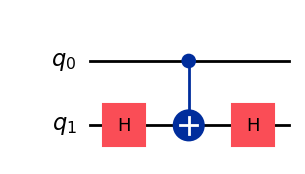

In [6]:
# Here's our new winner
QUANTUM_WINNER = '11'

# Let's get the oracle circuit that will mark our winner
grover_oracle = get_grover_oracle(QUANTUM_WINNER)
grover_oracle.decompose().draw(output='mpl')

In [7]:
# We can convert this into it's own gate
grover_oracle = grover_oracle.to_gate(label='oracle')

We can set up a new quantum system and see what this gate does to the state vectors.

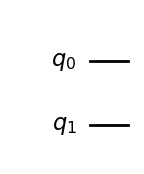

In [8]:
circuit = qs.QuantumCircuit(len(QUANTUM_WINNER))
circuit.draw(output='mpl')

First we can take a look at the state vectors of an initial quantum state.

In [9]:
# Helper function to display the state vectors
def get_state_vectors(circuit):
    simulator = aer.StatevectorSimulator()
    result = simulator.run(circuit.decompose()).result()
    sv = np.round(result.get_statevector(), 3)
    state_labels = [f"{i:0{len(QUANTUM_WINNER)}b}" for i in range(2**len(QUANTUM_WINNER))]
    df = pd.DataFrame(np.array([state_labels, sv]).T, columns=['State', 'Vector'])
    display(df)
    return sv

In [10]:
sv = get_state_vectors(circuit)

,State,Vector
0,00,(1+0j)
1,01,0j
2,10,0j
3,11,0j


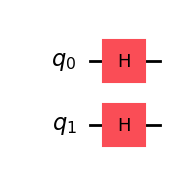

In [11]:
# Now let's apply the hadamard gates to put the qubits in superposition
circuit.h(range(len(QUANTUM_WINNER)))
circuit.draw(output='mpl')

In [12]:
sv = get_state_vectors(circuit)

,State,Vector
0,00,(0.5+0j)
1,01,(0.5+0j)
2,10,(0.5+0j)
3,11,(0.5+0j)


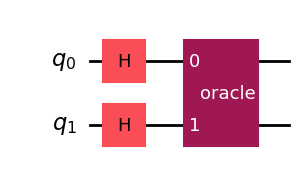

In [13]:
# And finally lets add our oracle
# Now let's apply the hadamard gates to put the qubits in superposition
circuit.append(grover_oracle, range(len(QUANTUM_WINNER)))
circuit.draw(output='mpl')

In [14]:
sv = get_state_vectors(circuit)

,State,Vector
0,00,(0.5+0j)
1,01,(0.5+0j)
2,10,(0.5+0j)
3,11,(-0.5+0j)


You can see that the winner state has been marked by changing it's amplitude. Now that our winner state is marked we can apply the next part of the algorithm.

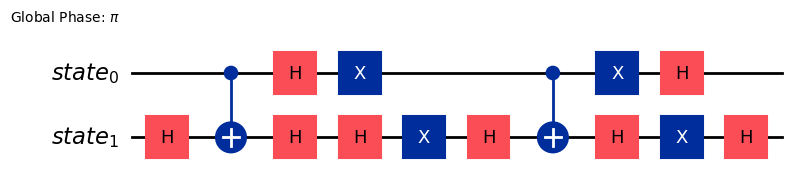

In [15]:
# The grover operator is built into qiskit; we can decompose
# so we can see what it is composed of.

grover_op = GroverOperator(get_grover_oracle(QUANTUM_WINNER).decompose())
grover_op.decompose().draw(output='mpl')

So this Grover's operator will alter our quantum state and slowly map the probability amplitudes onto the marked states. There is an equation to calculate the optimum number of operations to perform.

In [16]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(1 / 2**grover_op.num_qubits)))
)
print(f"Optimal number of iterations: {optimal_num_iterations}")

Optimal number of iterations: 1


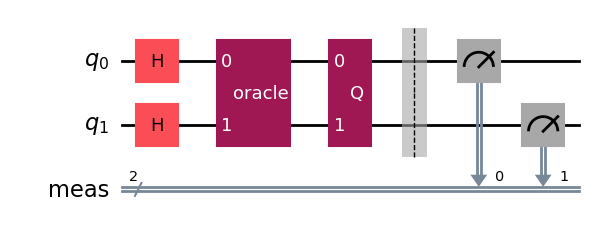

In [17]:
# Now we can apply the grover operator to our circuit twice.

for i in range(optimal_num_iterations):
    circuit.append(grover_op.decompose(), range(grover_op.num_qubits))

# Our cicuit is now finished and we can measure the state of all
# quibits to get the result.
circuit.measure_all()
circuit.draw(output='mpl')

<BarContainer object of 4 artists>

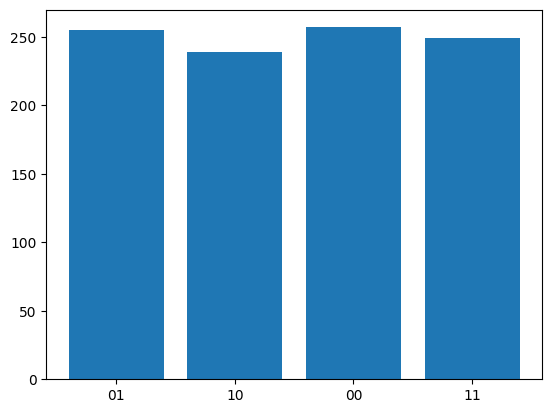

In [18]:
simulator = aer.QasmSimulator()
result = simulator.run(circuit.decompose(), shots=1000).result()
counts = result.get_counts()

plt.bar(counts.keys(), counts.values())

Let's tidy this into a neat little function so that we can test some other cases. For simplicity we will redefine the problem slightly:

- The list will contain numbers 0 to $2^n$ where $n$ is a integer number of qubits.
- The winner is any number form the list.

In [19]:
# Helper functions

def get_state_map(my_list, n):
    state_map = {}
    for i, val in enumerate(my_list):
        state_map[val] = f"{i:0{n}b}"
    return state_map

def convert_to_quantum_state(value, state_map):
    return state_map[value]

def convert_to_classical_value(state, state_map: dict):
    for key, val in state_map.items():
        if val == state:
            return key

def get_quantum_state(list):
    n = math.ceil(math.log2(max(list)+1))
    state_map = get_state_map(list)
    states = []
    for number in list:
        states.append(convert_to_quantum_state(number, state_map))
    return states

def convert_counts_to_classical(counts, state_map):
    classical_counts = {}
    for key in counts.keys():
        new_key = convert_to_classical_value(key, state_map)
        classical_counts[new_key] = counts[key]
    return classical_counts

def create_plotting_counts(counts, list):
    for i, val in enumerate(list):
        if val not in counts.keys():
            counts[val] = 0

    return counts

def get_key_with_max_val(dictionary):
    return max(dictionary, key=dictionary.get)

In [20]:
def get_winner(my_list, winner, shots=1000):

    n = math.ceil(math.log2(max(my_list)+1))

    state_map = get_state_map(my_list, n)

    winner_state = convert_to_quantum_state(winner, state_map)

    grover_oracle = get_grover_oracle(winner_state)

    grover_op = GroverOperator(grover_oracle)

    optimal_num_iterations = math.floor(
        math.pi / (4 * math.asin(math.sqrt(1 / 2**grover_op.num_qubits)))
    )

    circuit = qs.QuantumCircuit(grover_op.num_qubits)
    circuit.h(range(grover_op.num_qubits))
    
    for i in range(optimal_num_iterations):
        circuit.append(grover_op.decompose(), range(grover_op.num_qubits))
    
    circuit.measure_all()
    circuit = circuit.decompose()

    simulator = aer.QasmSimulator()
    result = simulator.run(circuit.decompose(), shots=shots).result()
    counts = result.get_counts()

    classical_counts = convert_counts_to_classical(counts, state_map)
    plotting_counts = create_plotting_counts(classical_counts, my_list)

    result_df = pd.DataFrame(plotting_counts.items(), columns=['Value', 'Count'])
    

    # create a my_list of labels
    tick_label = [str(i) for i in list(result_df['Value'])]
    plt.bar(result_df['Value'], result_df['Count'], tick_label=tick_label)
    plt.show()

    winner = get_key_with_max_val(classical_counts)
    
    print(f"Winner is {winner} with {classical_counts[winner]} votes")

    return winner

In [21]:
# Number of quibits to use
n = 6

# Create a list of unique random numbers
my_list = np.random.choice(np.arange(2**n), 2**n, replace=False)

# Pick a random winner
my_winner = np.random.choice(my_list)

print(f"List: {my_list}")
print(f"Winner: {my_winner}")

List: [ 6 34 19 61  5  2 27 32 33 43 12 11 51 60 55 44 58 15 53  8 41 22 29 62
  0 40 10 59 18 39 37 49 21 24 14 26  4 57 20 48 46 38 36 25 23 47 28  7
  1  3 52 50 35  9 30 16 17 54 63 42 56 13 45 31]
Winner: 36


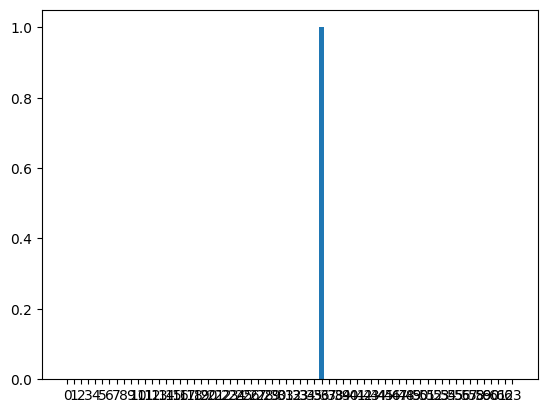

Winner is 36 with 1 votes


In [22]:
_ = get_winner(my_list, my_winner, shots=1)